## Monte Carlo Integration

This tutorial uses the same example as the [example introduction](../example_introduction.ipynb).
In other words:

In [1]:
import numpy
from matplotlib import pyplot
import chaospy
from chaospy.example import (
    coordinates, exponential_model, distribution)

Monte Carlo is the simplest of all collocation methods.
It consist of the following steps:

* Generate (pseudo-)random samples $q_1, ..., q_N = (I_1, R_1), ..., (I_N, R_N)$.
* Evaluate model predictor $U_1, ..., U_N$ for each sample.
* Use empirical metrics to assess statistics on the evaluations.

As an alternative to (pseudo-)random, it is also possible to use a [low-discrepancy sequences](https://en.wikipedia.org/wiki/Low-discrepancy_sequence).
These are structured sequences designed to behave as random, but also to minimize the gaps in the sampling, leading to better performance.

Below we will do the analysis both for classical (pseudo-)random samples, but also for the [Halton sequence](https://en.wikipedia.org/wiki/Halton_sequence).
Other low-discrepancy sequences also exist.

### Generating samples

In chaospy, creating (pseudo-)random samples and low-discrepancy sequences can be done using the ``sample`` method.

In [2]:
# Sampling schemes we want to include
rules = ["random", "halton"]

# Fix random seed to enforce determinism
numpy.random.seed(123)

# Generate samples for both schemes
number_of_samples = 10000
samples = {rule: distribution.sample(
    number_of_samples, rule=rule) for rule in rules}

assert samples["random"].shape == samples["halton"].shape == (2, 10000)

The two schemes represents two different approaches.
While ``random`` is designed to pass as random as well as possible, ``halton`` is designed to not cluster.
This is quite visible when visualizing the samples.

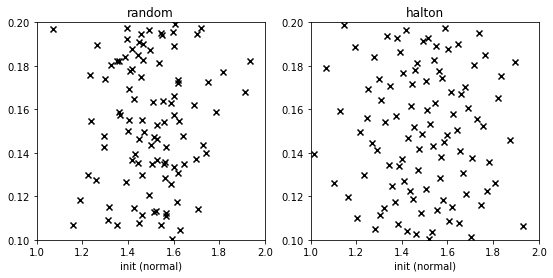

In [3]:
# increase figure width to better fit two plots
pyplot.rc("figure", figsize=[9, 4])

for idx, rule in enumerate(rules, start=1):
    pyplot.subplot(1, 2, idx)
    
    # Show samples as 2-dimensional scatter plot
    pyplot.scatter(*samples[rule][:, :100], marker="x", color="k")
    
    # Make scatter figures pretty
    pyplot.xlabel("init (normal)")
    pyplot.ylabel("rate (uniform)") if not idx else None
    pyplot.axis([1, 2, 0.1, 0.2])
    pyplot.title(rule)
    
pyplot.show()

### Evaluating model predictor

Creating model predictions is fairly straight forward.
Just note that the (random) samples generated has shape `(dimensions, number_of_samples)`.
As such, it is important to transpose when iterating over samples.

In [4]:
# Evaluate model predictor for every sample
evaluations = {
    rule: numpy.array([exponential_model(sample)
                       for sample in samples[rule].T])
    for rule in rules
}

assert evaluations["random"].shape == evaluations["halton"].shape == (10000, 1000)

These model evaluations can be visualized, however ti is hard to observe the difference between the two schemes from these plots.

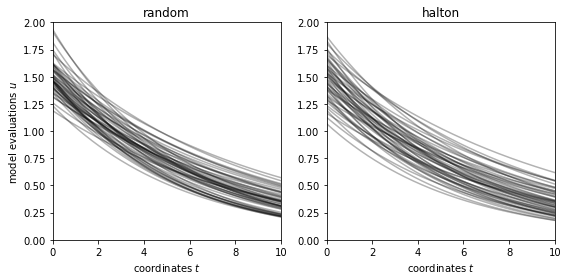

In [5]:
for idx, rule in enumerate(rules):
    pyplot.subplot(1, 2, idx+1)
    
    # Make a plot line for the first 50 evaluations
    for evals in evaluations[rule][:50]:
        pyplot.plot(coordinates, evals, "k-", alpha=0.3)
    
    # Make plot pretty
    pyplot.xlabel("coordinates $t$")
    pyplot.ylabel("model evaluations $u$") if not idx else None
    pyplot.title(rule)
    pyplot.axis([0, 10, 0, 2])

pyplot.show()

### Assess Statistics

While the true statistics are calculated from the mathematical definition, in Monte Carlo integration, the statistics are calculated using the empirical counterpart for each metric.
For mean and variance, these counterparts are average and sample variance:

$$
        \mbox E(U) \approx \tfrac 1N \sum_{n=1}^N U_n \qquad
        \mbox{Var}(U) \approx \left(\tfrac 1N\sum U_n^2\right) - \left(\tfrac 1N \sum_{n=1}^N U_n\right)^2
$$

Which numerically becomes:

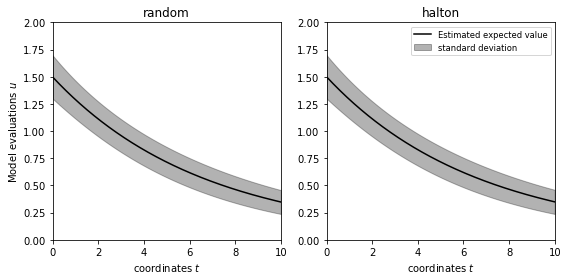

In [6]:
for idx, rule in enumerate(rules):
    
    pyplot.subplot(1, 2, idx+1)
    
    # Estimate mean and variance
    expected = numpy.mean(evaluations[rule], axis=0)
    variance = numpy.var(evaluations[rule], axis=0)

    # Create band one standard deviation away from mean 
    pyplot.fill_between(coordinates, expected-variance**0.5,
                        expected+variance**0.5, alpha=0.3,
                        color="k", label="standard deviation")
    pyplot.plot(coordinates, expected, "k-",
                label="Estimated expected value")

    # Make plot pretty
    pyplot.xlabel("coordinates $t$")
    pyplot.axis([0, 10, 0, 2])
    pyplot.title(rule)
    if idx:
        pyplot.legend()
    else:
        pyplot.ylabel("Model evaluations $u$")
    
pyplot.show()

### Error Analysis

It is hard to assess how well these models are doing from the final estimation alone.
They look about the same.
So to compare results, we do error analysis.
To do so, we use the reference analytical solution and error function as defined in  [example introduction](../example_introduction.ipynb).

In [7]:
# NBVAL_CHECK_OUTPUT
from chaospy.example import error_mean, error_variance

error_mean(expected).round(10), error_variance(variance).round(11)

(5.11571e-05, 9.97905e-06)

To illustrate the difference in a common format, we plot error as a function of the number of samples used in a logarithmic plot.

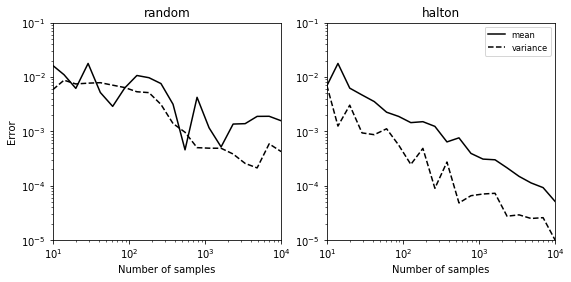

In [8]:
# Estimate mean and variance for various number of samples
sizes = (10**numpy.linspace(1, 4, 20)).astype(int)
estimated_mean = {
    rule: [numpy.mean(evaluations[rule][:size], axis=0)
           for size in sizes] for rule in rules
}
estimated_variance = {
    rule: [numpy.var(evaluations[rule][:size], axis=0)
           for size in sizes] for rule in rules
}

for idx, rule in enumerate(rules):
    
    pyplot.subplot(1, 2, idx+1)
    
    # error plot for mean
    errors = [error_mean(mean)
              for mean in estimated_mean[rule]]
    pyplot.loglog(sizes, errors, "k-", label="mean")
    
    # error plot for variance
    errors = [error_variance(variance)
              for variance in estimated_variance[rule]]
    pyplot.loglog(sizes, errors, "k--", label="variance")
    
    # make plot pretty
    pyplot.axis([10, 10000, 1e-5, 1e-1])
    pyplot.title(rule)
    pyplot.xlabel("Number of samples")
    pyplot.legend() if idx else pyplot.ylabel("Error")
    
pyplot.show()

### Comparing Different Sample Schemes

So far only `random` and `halton` has been compared. In `chaospy` there are many sampling schemes.
They are as follow:

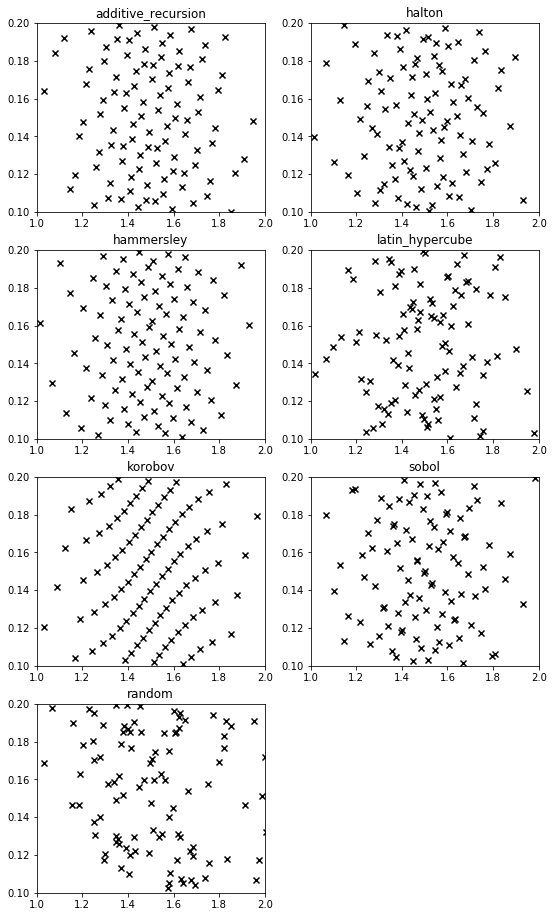

In [9]:
pyplot.rc("figure", figsize=[9, 16])
pyplot.rc("figure.subplot", hspace=0.2)
sampling_rules = ["additive_recursion", "halton", "hammersley",
                  "latin_hypercube", "korobov", "sobol", "random"]

for idx, rule in enumerate(sampling_rules, start=1):
    pyplot.subplot(4, 2, idx)
    
    pyplot.scatter(*distribution.sample(100, rule=rule), marker="x", color="k")
    pyplot.axis([1, 2, 0.1, 0.2])
    pyplot.title(rule)
    
pyplot.show()

For a fix number of point, it is possible to compare the different schemes against each other. For example:

In [10]:
# NBVAL_CHECK_OUTPUT
for rule in sampling_rules:
    samples = distribution.sample(1000, rule=rule)
    evals = numpy.array([exponential_model(sample)
                         for sample in samples.T])
    mean = numpy.mean(evals, axis=0)
    variance = numpy.var(evals, axis=0)
    print(f"{rule:<20} {error_mean(mean):.6f} {error_variance(variance):.6f}")

additive_recursion   0.000210 0.000198
halton               0.000272 0.000127
hammersley           0.000608 0.000350
latin_hypercube      0.000192 0.000334
korobov              0.001730 0.000172
sobol                0.000228 0.000140
random               0.007120 0.000570
